In [1]:
import pandas as pd
import os
import json
from graphs import subplots_attributes, subplots_pie, plot_attribute, plot_attribute2attribute

# Load data and graphs param

In [2]:
stock = pd.read_csv('building_stock_sdes2018_aggregated.csv', index_col=[0, 1, 2, 3, 4, 5]).squeeze()

In [3]:
with open('colors.json') as file:
    dict_color = json.load(file)

dict_order = {'Income tenant': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'],
          'Income owner': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'],
          'Heating energy': ['Electricity', 'Natural gas', 'Oil fuel', 'Wood fuel'],
          'Energy performance': ['G', 'F', 'E', 'D', 'C', 'B', 'A'],
          'Housing type': ['Single-family', 'Multi-family'],
          'Occupancy status': ['Owner-occupied', 'Privately rented', 'Social-housing']
         }

order_attributes = ['Housing type', 'Heating energy', 'Energy performance', 'Occupancy status', 'Income owner', 'Income tenant']
stock = stock.reorder_levels(order_attributes)

# Make graphs

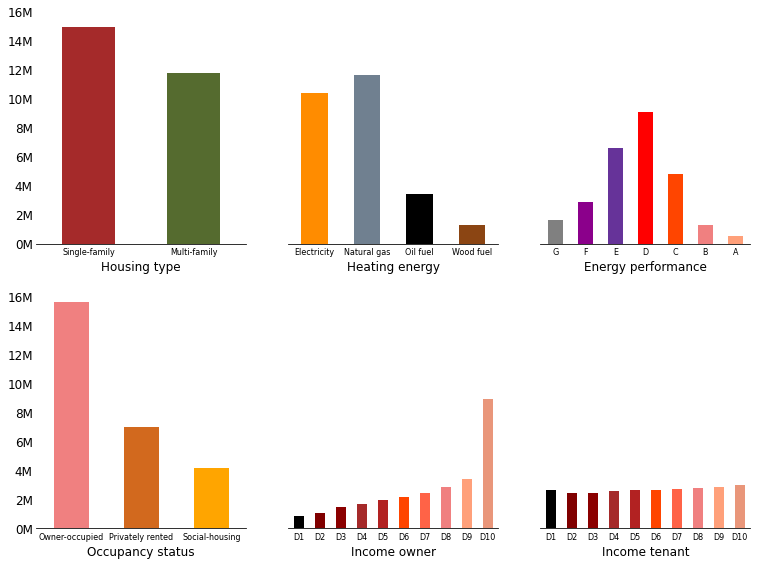

In [4]:
#subplots_attributes(stock, dict_order=dict_order, suptitle=None, dict_color=dict_color, option='percent', sharey=True)
subplots_attributes(stock, dict_order=dict_order, dict_color=dict_color, percent=False, sharey=True)
subplots_attributes(stock, dict_order=dict_order, dict_color=dict_color, percent=False, sharey=True, save='output/stock_sdes2018_all.png')

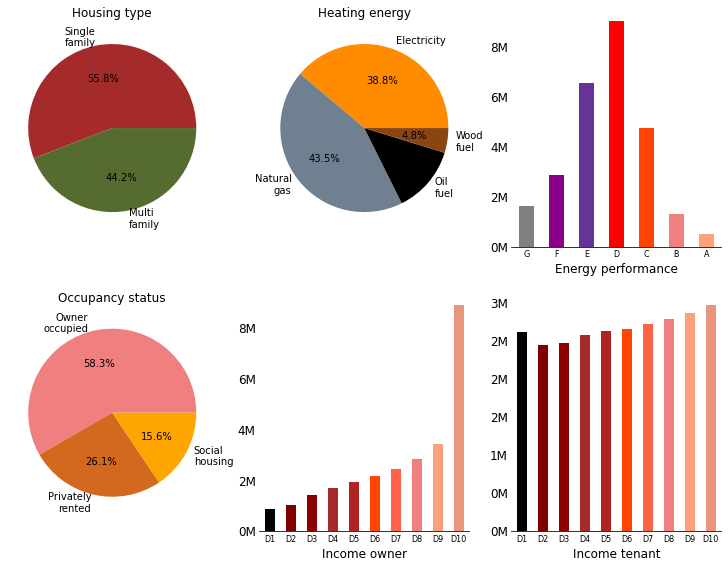

In [5]:
subplots_pie(stock, dict_order=dict_order, pie={'Housing type', 'Heating energy', 'Occupancy status'}, dict_color=dict_color, percent=False)


In [6]:
plot_attribute(stock, attribute='Energy performance', dict_order=dict_order, percent=False, dict_color=dict_color, width=0.4,
               save='output/stock_sdes2018_energy_performance.png', figsize=(8.0, 6.0))

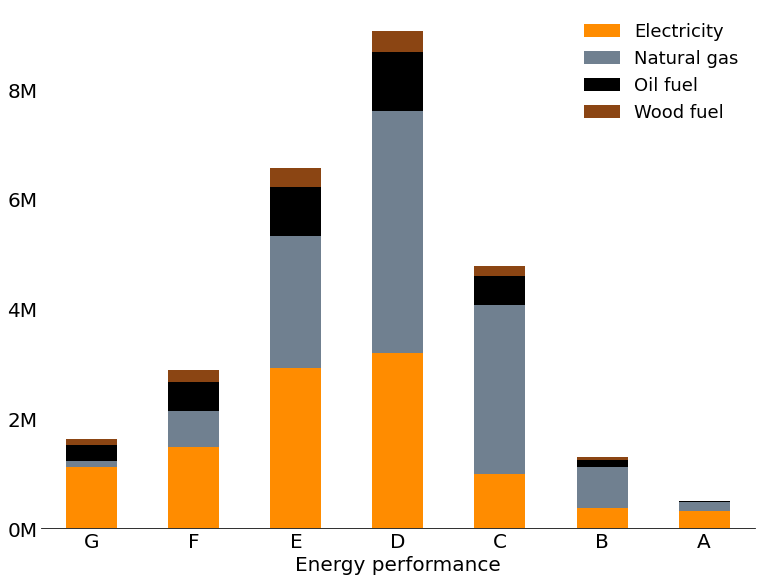

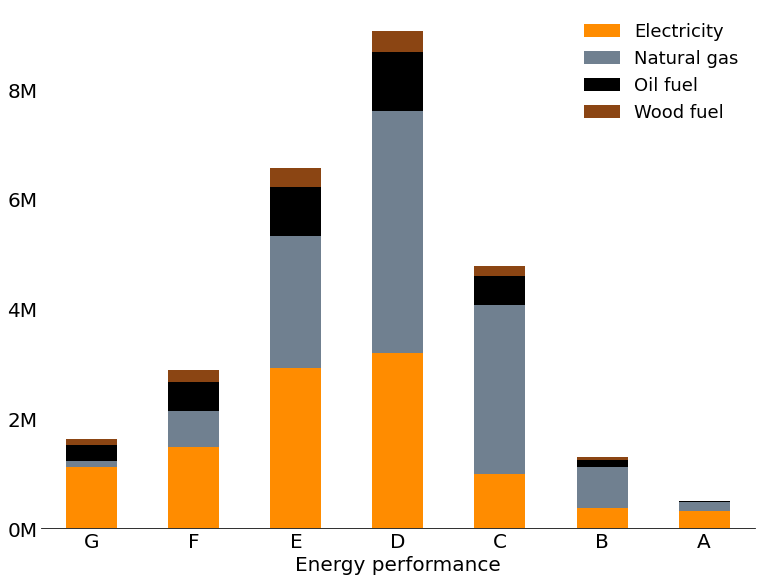

In [7]:
plot_attribute2attribute(stock, 'Energy performance', 'Heating energy', dict_order=dict_order, dict_color=dict_color)
plot_attribute2attribute(stock, 'Energy performance', 'Heating energy', dict_order=dict_order, dict_color=dict_color, percent=False)
plot_attribute2attribute(stock, 'Energy performance', 'Heating energy', dict_order=dict_order, dict_color=dict_color, percent=False, save='output/stock_sdes2018_dpe_energy.png')

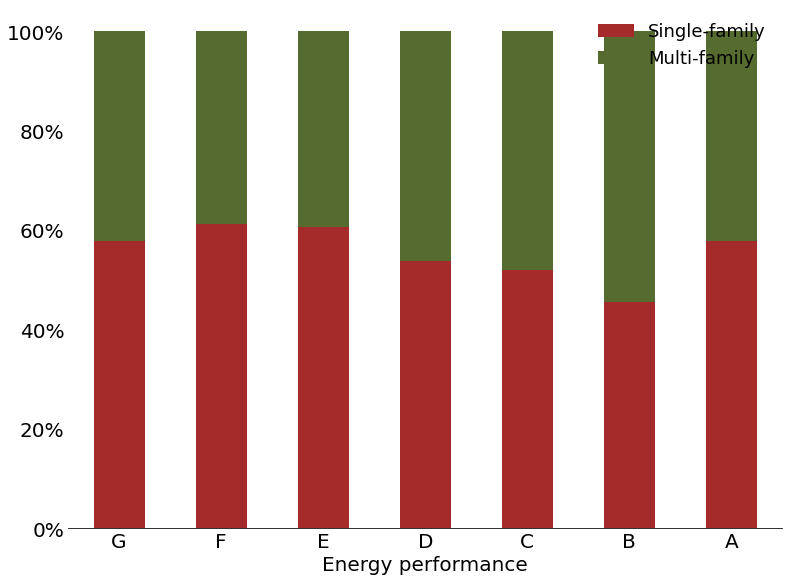

In [7]:
plot_attribute2attribute(stock, 'Energy performance', 'Housing type', dict_order=dict_order, dict_color=dict_color, percent=True)

In [8]:
stock.groupby(['Energy performance', 'Heating energy']).sum().unstack('Heating energy')

Heating energy,Electricity,Natural gas,Oil fuel,Wood fuel
Energy performance,,,,
A,3.066313e+05,1.699846e+05,2.129077e+04,8081.707109
B,3.697614e+05,7.549601e+05,1.223251e+05,43937.077179
C,9.957906e+05,3.079008e+06,5.205021e+05,178762.381050
D,3.187205e+06,4.422417e+06,1.072973e+06,375823.947849
E,2.921526e+06,2.411488e+06,8.896843e+05,338107.687055
F,1.473983e+06,6.602216e+05,5.381198e+05,214421.580731
G,1.112649e+06,1.203295e+05,2.774088e+05,111297.968482


In [9]:
(stock.groupby(['Energy performance', 'Heating energy']).sum().unstack('Heating energy').T / stock.groupby(['Energy performance', 'Heating energy']).sum().unstack('Heating energy').sum(axis=1)).T

Heating energy,Electricity,Natural gas,Oil fuel,Wood fuel
Energy performance,,,,
A,0.606005,0.335946,0.042078,0.015972
B,0.286418,0.584794,0.094753,0.034034
C,0.208583,0.644945,0.109027,0.037444
D,0.351850,0.488211,0.118450,0.041489
E,0.445300,0.367560,0.135606,0.051534
F,0.510604,0.228708,0.186411,0.074278
G,0.686107,0.074200,0.171062,0.068631


In [10]:
d = stock.groupby(['Energy performance', 'Heating energy', 'Income tenant']).sum().unstack('Income tenant').loc[:, ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']]
d.to_csv('income_absolute.csv')
# (d.T / d.sum(axis=1)).T.to_csv('income_percent.csv')

# Consumption

In [11]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')
from utils import reindex_mi

In [12]:
def to_consumption(stock, surface, income, energy_prices, consumption_conventional):

    surface = reindex_mi(surface, stock.index)
    income = reindex_mi(income, stock.index)
    energy_prices = reindex_mi(energy_prices, stock.index)
    consumption_conventional = reindex_mi(consumption_conventional, stock.index)

    budget_share = (surface * consumption_conventional * (energy_prices / income).T).T
    heating_intensity = -0.191 * budget_share.apply(np.log) + 0.1105
    consumption_actual = (consumption_conventional * heating_intensity.T).T

    return consumption_actual * surface * stock

## Additional input

In [13]:

stock = pd.read_csv('building_stock_sdes2018_aggregated.csv', index_col=[0, 1, 2, 3, 4, 5]).squeeze()

income = pd.Series([13628, 20391, 24194, 27426, 31139, 35178, 39888, 45400, 54309, 92735],
                   index=pd.Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'], name='Income tenant'))

surface = pd.read_csv('../input/surface.csv', index_col=[0, 1, 2]).xs(True, level='Existing').squeeze()

energy_prices = pd.Series([0.1714, 0.082, 0.0931, 0.0615],
                          index=pd.Index(['Electricity', 'Natural gas', 'Oil fuel', 'Wood fuel'],
                                         name='Heating energy'))

consumption_conventional = pd.read_csv('consumption.csv', index_col=[0, 1]).squeeze()


consumption_ceren = pd.Series([33, 117, 36, 79], index=pd.Index(['Electricity', 'Natural gas', 'Oil fuel', 'Wood fuel'],
                                                                name='Heating energy'))

## Calculation

Consumption in TWh/year
Stock in millions of dwellings

In [14]:
consumption = to_consumption(stock, surface, income, energy_prices, consumption_conventional)
consumption_energy = consumption.groupby('Heating energy').sum() / 10**9

coefficient = consumption_ceren / consumption_energy

consumption = consumption * reindex_mi(coefficient, consumption.index)
consumption_dpe = consumption.groupby(['Energy performance', 'Heating energy']).sum().unstack('Heating energy')
consumption_dpe['Total consumption'] = consumption_dpe.sum(axis=1)
consumption_dpe = consumption_dpe / 10**9

consumption_dpe['Total stock'] = stock.groupby('Energy performance').sum() / 10**6
consumption_dpe.loc['Total', :] = consumption_dpe.sum()

consumption_dpe

Heating energy,Electricity,Natural gas,Oil fuel,Wood fuel,Total consumption,Total stock
Energy performance,,,,,,
A,0.318952,0.595839,0.072370,0.153932,1.141093,0.505988
B,0.455049,3.478259,0.518518,1.066139,5.517965,1.290984
C,1.785253,21.138449,3.031337,6.089743,32.044783,4.774063
D,7.877845,43.326040,8.825553,18.107326,78.136765,9.058419
E,9.825863,33.470577,10.123193,22.236607,75.656239,6.560806
F,6.334332,12.124052,8.041519,18.545706,45.045609,2.886746
G,6.402706,2.866783,5.387510,12.800546,27.457545,1.621685
Total,33.000000,117.000000,36.000000,79.000000,265.000000,26.698691


In [15]:
d = consumption.groupby(['Energy performance', 'Heating energy', 'Income tenant']).sum().unstack('Income tenant')
# d.to_csv('consumption_income.csv')

# (d.T / d.sum(axis=1)).T.to_csv('consumption_income_percent.csv')